# ANALYSE DE SALAIRE DANS LE SECTEUR PRIVE 

## A- **__**

### **1. Description de la base de donnée**

* **Source** : INSEE, Base Tous Salariés (BTS).
* **Période** : 2022–2023.
* **Population** : salariés du privé (hors apprentis, stagiaires, agricoles, particuliers employeurs).
* **Variable principale** :

  * `OBS_VALUE` = salaire net moyen mensuel en équivalent temps plein.
* **Variables disponibles** :

  * `SEX` → Sexe (hommes, femmes).
  * `PCS_ESE` → Catégorie socioprofessionnelle.
  * `DERA_MEASURE` → methode de mesure de variable cible
  * `GEO`→ Localisation géographique
  * `GEO_OBJECT` → Niveau géographique (commune, département, France, etc.).
  * `FREQ` → Frequence de publication annuel
  * `TIME_PERIOD` → période temporelle (année N et N-1).
  * `CONF_STATUS` → statut de confidentialité.

* **Taille** : **370 710** lignes, **9** variables.

* **Explications des modalités de GEO_OBJECT**

| Code GEO_OBJECT | Signification | Niveau géographique |
|-----------------|---------------|---------------------|
| BV2022 | Bureau de vote 2022 | Très local / électoral |
| ARR | Arrondissement | Niveau départemental subdivisé |
| AAV2020 | Aire d'Attraction des Villes 2020 | Zone fonctionnelle autour des villes |
| COM | Commune | Niveau le plus fin : ville ou village |
| UU2020 | Unité Urbaine 2020 | Agglomération / unité urbaine |
| ARM | Aire de Recensement Métropolitaine | Zone statistique pour recensement |
| EPCI | Établissement Public de Coopération Intercommunale | Groupement de communes |
| ZE2020 | Zone d'Emploi 2020 | Zone pour les statistiques de l'emploi |
| DEP | Département | Niveau administratif intermédiaire |
| FRANCE | France entière | Niveau national |
| REG | Région | Niveau régional |


⚠️ **Précautions** :

* Salaires en euros courants (pas corrigés de l’inflation).
* Données fiables surtout au niveau départemental ou supérieur (au-delà, prudence).
* Zones < 2 000 habitants non diffusées.

---

### **2. Data Canvas complété**

#### 🔹 Définition claire de la problématique

L’objectif est de 
 **Modéliser et expliquer les  disparités de salqriqles dans le secteur privé français en fonction du sexe, de la catégorie socioprofessionnelle et du territoire, afin de prédire  les niveaux de rémunération.**

 **Prédiction** → prédire le salaire moyen EQTP mensuel en fonction du sexe, de la PCS et de la localisation parce la variable cible est **quantitative continue**

---

####  Variable cible

* **Variable cible** : `SALAIRE_NET_EQTP_MENSUEL_MOYENNE`.
* **Justification** : mesure centrale des salaires, comparable car exprimée en EQTP.

---

#### Variables explicatives retenues

* **SEX** : influence directe (inégalités salariales hommes/femmes).
* **PCS** : structure professionnelle (cadres, ouvriers, employés, etc.).
* **GEO_OBJECT** : niveau territorial (impact du contexte local/urbain).
* **TIME_PERIOD** : pour analyser l’évolution dans le temps.
* **Interactions possibles** : Sexe × PCS, Sexe × Géographie.

---

####  Hypothèses initiales

1. **Effet du sexe** : à PCS et zone égales, le salaire moyen des hommes est plus élevé que celui des femmes (hypothèse d’inégalités salariales).
2. **Effet de la PCS** : les cadres gagnent en moyenne plus que les employés et ouvriers.
3. **Effet géographique** : les salaires sont plus élevés dans les grandes villes et régions attractives (IDF, grandes métropoles).
4. **Effet temporel** : légère hausse entre 2022 et 2023 (mais non corrigée de l’inflation).

---

**Résumé** : Salaire net mensuel en équivalent temps plein dans le secteur privé selon le sexe et la catégorie socioprofessionnelle, en fonction du lieu de travail à divers niveaux géographiques : commune, arrondissement municipal, arrondissement, aire d'attraction des villes 2020, bassin de vie 2022, établissement public de coopération intercommunal, unité urbaine 2020, zone d'emploi 2020, département, région, France hors Mayotte.

Nous allons essayer de vérifier les hypothèses ci-dessus et de prédire le salaire en fonction de genre , localisation de travail et le statut des individus 

---



## B- **ANALYSE ET PREDICTION de Salaire**

##### Bibliothèques utilisées

In [164]:
# 1. Import des librairies
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt





##### Importer et lire la base de données

In [165]:
#lien vers la base de donnée
DATA_PATH = r"dataset/DS_BTS_SAL_EQTP_SEX_PCS_2023_data.csv"
META_PATH = r"dataset/DS_BTS_SAL_EQTP_SEX_PCS_2023_metadata.csv"
CLEAN_DATA_PATH = r"dataset/clean_data.csv"

In [166]:
# 2. Charger le dataset
df = pd.read_csv(DATA_PATH,sep=";")


In [167]:
display(df)

,GEO,GEO_OBJECT,FREQ,SEX,PCS_ESE,DERA_MEASURE,CONF_STATUS,TIME_PERIOD,OBS_VALUE
0,26362,BV2022,A,F,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2157.284701
1,26324,BV2022,A,_T,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,3112.937532
2,26307,BV2022,A,_T,6,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2013.097449
3,26362,BV2022,A,_T,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2483.037253
4,27170,BV2022,A,F,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2107.221064
...,...,...,...,...,...,...,...,...,...
370705,35217,UU2020,A,M,6,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2098.370503
370706,35222,UU2020,A,F,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2180.473828
370707,35217,UU2020,A,_T,6,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2029.421385
370708,35302,UU2020,A,_T,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2394.345641


In [168]:
df.shape

(370710, 9)

In [169]:
# type des colonnes, valeurs manquantes
print(df.info())
# stats numériques
print(df.describe())
# nb de valeurs uniques par colonne
print(df.nunique())   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370710 entries, 0 to 370709
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   GEO           370710 non-null  object 
 1   GEO_OBJECT    370710 non-null  object 
 2   FREQ          370710 non-null  object 
 3   SEX           370710 non-null  object 
 4   PCS_ESE       370710 non-null  object 
 5   DERA_MEASURE  370710 non-null  object 
 6   CONF_STATUS   370710 non-null  object 
 7   TIME_PERIOD   370710 non-null  int64  
 8   OBS_VALUE     350250 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 25.5+ MB
None
         TIME_PERIOD      OBS_VALUE
count  370710.000000  350250.000000
mean     2022.500000    2445.222636
std         0.500001     758.390930
min      2022.000000     793.398502
25%      2022.000000    1908.282620
50%      2022.500000    2191.887290
75%      2023.000000    2671.731583
max      2023.000000   14047.315035
GEO           

In [170]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370710 entries, 0 to 370709
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   GEO           370710 non-null  object 
 1   GEO_OBJECT    370710 non-null  object 
 2   FREQ          370710 non-null  object 
 3   SEX           370710 non-null  object 
 4   PCS_ESE       370710 non-null  object 
 5   DERA_MEASURE  370710 non-null  object 
 6   CONF_STATUS   370710 non-null  object 
 7   TIME_PERIOD   370710 non-null  int64  
 8   OBS_VALUE     350250 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 25.5+ MB


,GEO,GEO_OBJECT,FREQ,SEX,PCS_ESE,DERA_MEASURE,CONF_STATUS,TIME_PERIOD,OBS_VALUE
0,26362,BV2022,A,F,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2157.284701
1,26324,BV2022,A,_T,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,3112.937532
2,26307,BV2022,A,_T,6,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2013.097449
3,26362,BV2022,A,_T,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2483.037253
4,27170,BV2022,A,F,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2107.221064


**Distribution générale des salaires**


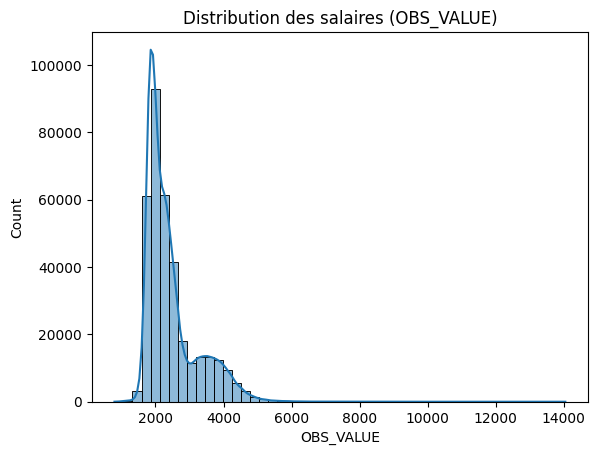

In [171]:
sns.histplot(df["OBS_VALUE"].dropna(), bins=50, kde=True)
plt.title("Distribution des salaires (OBS_VALUE)")
plt.show()

**Salaire par sexe**

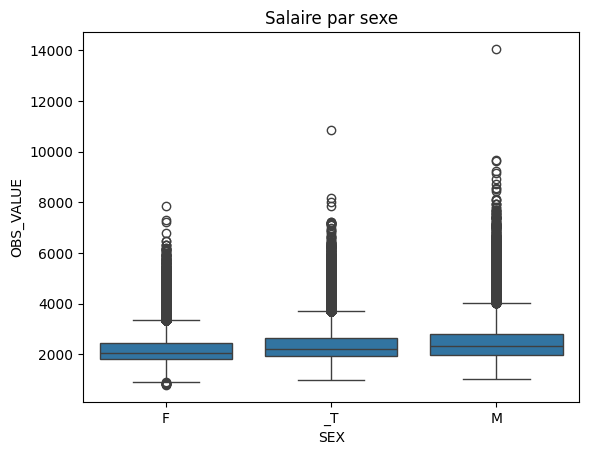

In [172]:
sns.boxplot(x="SEX", y="OBS_VALUE", data=df)
plt.title("Salaire par sexe")
plt.show()

**Salaire par profession (PCS_ESE)**

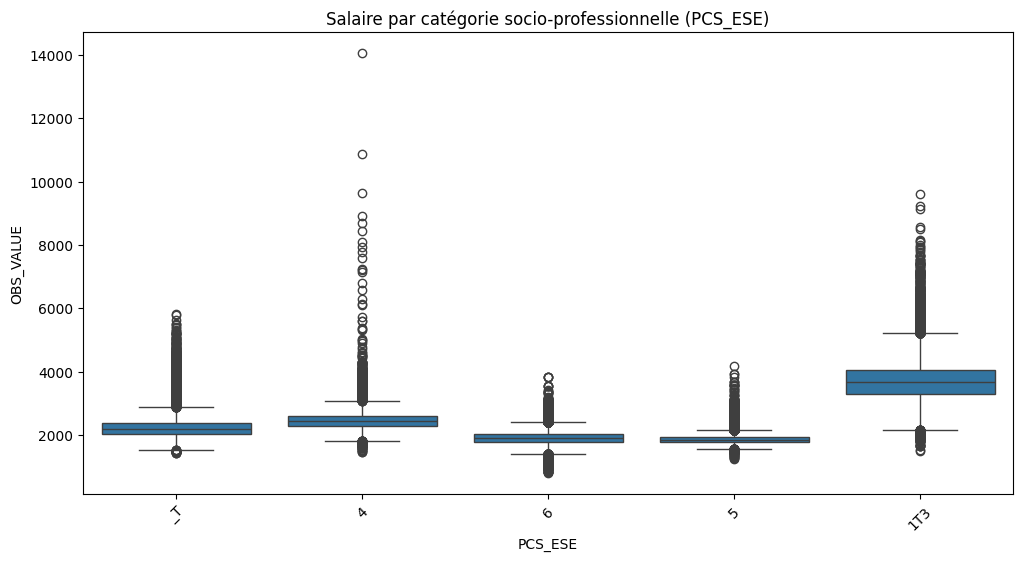

In [173]:
plt.figure(figsize=(12,6))
sns.boxplot(x="PCS_ESE", y="OBS_VALUE", data=df)
plt.xticks(rotation=45)
plt.title("Salaire par catégorie socio-professionnelle (PCS_ESE)")
plt.show()


**Évolution dans le temps**

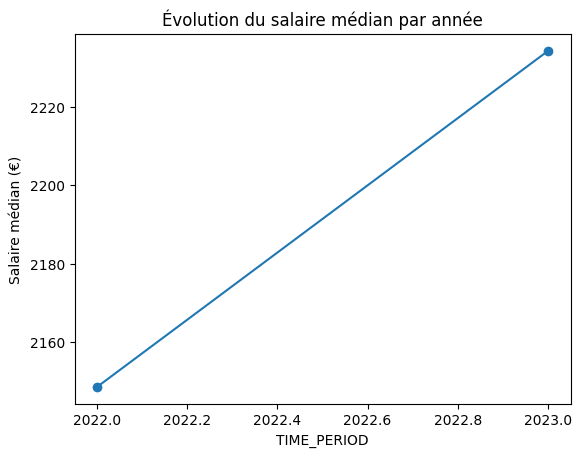

In [174]:
df.groupby("TIME_PERIOD")["OBS_VALUE"].median().plot(marker="o")
plt.title("Évolution du salaire médian par année")
plt.ylabel("Salaire médian (€)")
plt.show()

**Corrélations entre variables**

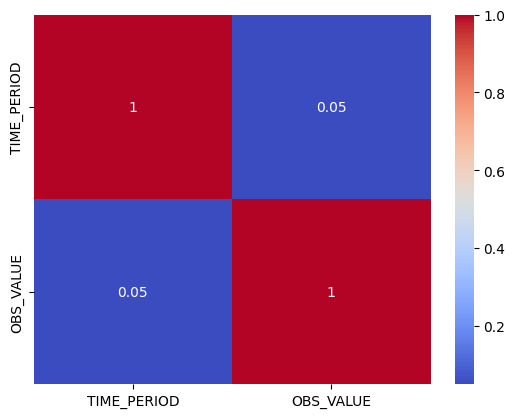

In [175]:
df.corr(numeric_only=True)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

**Analyse Géographique (GEO) TOP 10 region**

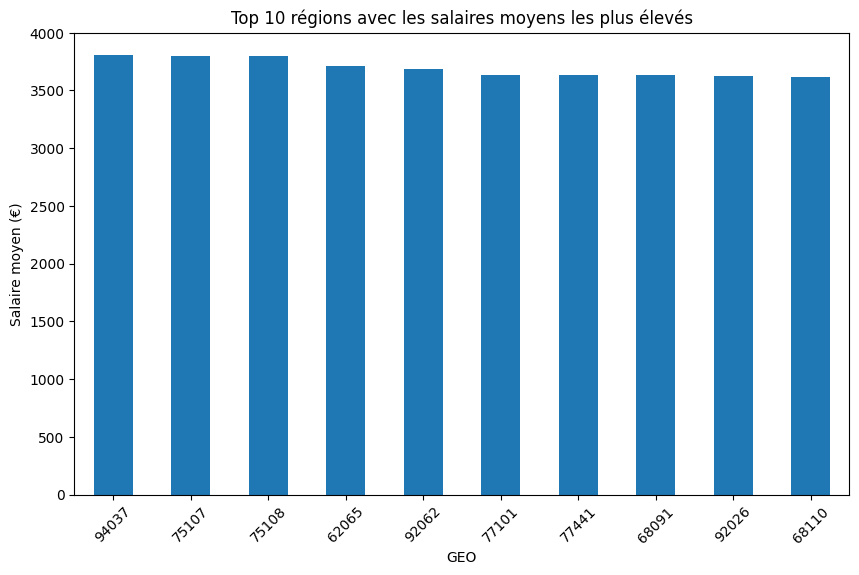

In [176]:
top10_geo = df.groupby("GEO")["OBS_VALUE"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top10_geo.plot(kind="bar")
plt.title("Top 10 régions avec les salaires moyens les plus élevés")
plt.ylabel("Salaire moyen (€)")
plt.xticks(rotation=45)
plt.show()

**Salaire moyen par sexe + profession**

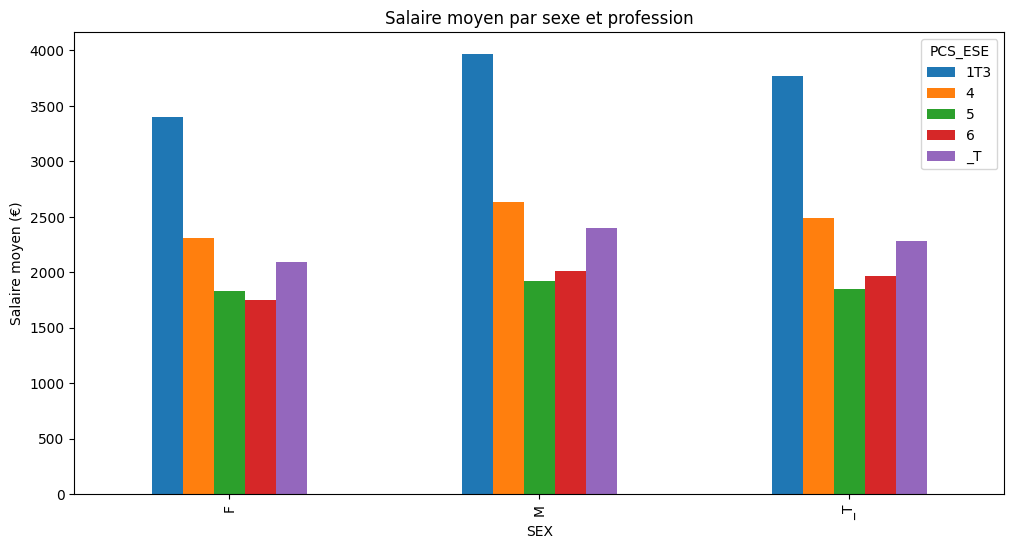

In [177]:
df.groupby(["SEX","PCS_ESE"])["OBS_VALUE"].mean().unstack().plot(kind="bar", figsize=(12,6))
plt.title("Salaire moyen par sexe et profession")
plt.ylabel("Salaire moyen (€)")
plt.show()

In [178]:
df = pd.read_csv(CLEAN_DATA_PATH)

**Encodage et normalisation**

In [179]:
# Supposons que df soit ton DataFrame
X = df.drop(columns=["OBS_VALUE", "DERA_MEASURE"]) #"GEO"
y = df["OBS_VALUE"]


# Colonnes par type
onehot_cols = ["GEO_OBJECT", "SEX"]
target_cols = ["PCS_ESE","GEO"]
#binary_cols = ["CONF_STATUS", "TIME_PERIOD"]  # ou OrdinalEncoder
binary_cols = ["TIME_PERIOD"] # Keep only 'TIME_PERIOD' as it's numerical
#num_cols = ["TIME_PERIOD"] # suppose que tu as une colonne Year
# Encoders
onehot_enc = OneHotEncoder(drop="first", handle_unknown='ignore', sparse_output=False)
target_enc = TargetEncoder(handle_unknown='ignore')
#scaler = StandardScaler()

# Préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", onehot_enc, onehot_cols),
        ("target", target_enc, target_cols),
        ("binary", "passthrough", binary_cols),  # or OrdinalEncoder
        #("num", scaler, num_cols),
    ],
    remainder='drop' # Drop any columns not specified in transformers
)

# Pipeline finale
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression()) # Add Linear Regression model here
])


In [180]:
# 7. Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Entraîner le modèle (Fit the pipeline)
pipeline.fit(X_train, y_train)

# 9. Prédictions (Predict on the test set using the pipeline)
y_pred = pipeline.predict(X_test)

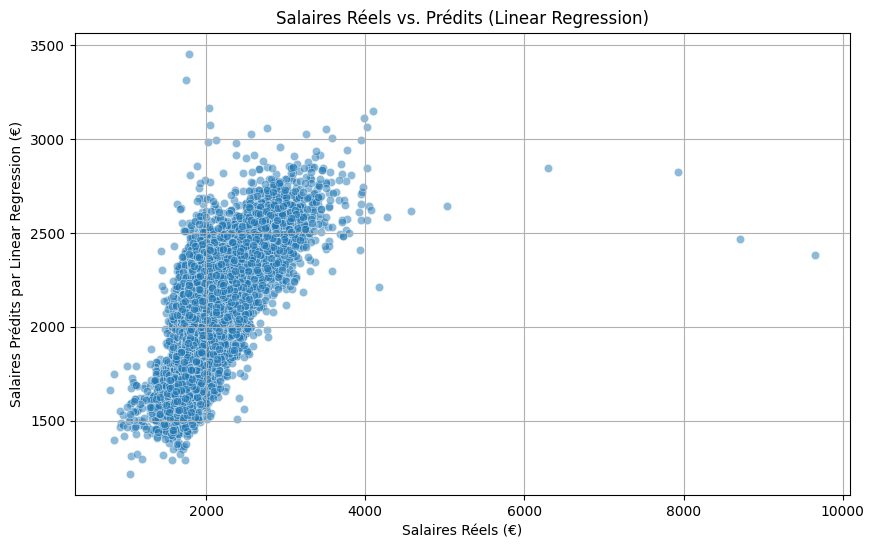

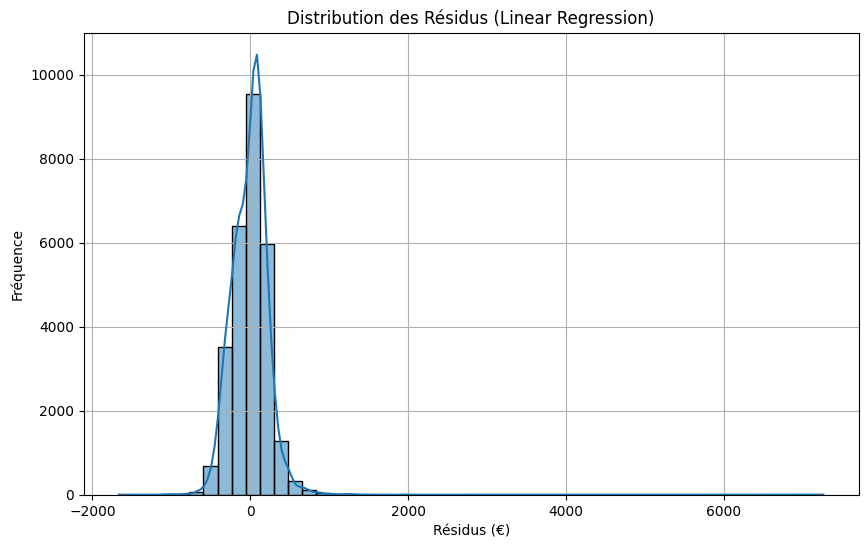

In [181]:
# Visualisation des résultats du modèle Linear Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Salaires Réels (€)")
plt.ylabel("Salaires Prédits par Linear Regression (€)")
plt.title("Salaires Réels vs. Prédits (Linear Regression)")
plt.grid(True)
plt.show()

# Histogram of residuals for Linear Regression
residuals_lr = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals_lr, bins=50, kde=True)
plt.xlabel("Résidus (€)")
plt.ylabel("Fréquence")
plt.title("Distribution des Résidus (Linear Regression)")
plt.grid(True)
plt.show()

In [182]:
# 10. Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Résultats du modèle :")
print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.2f}")



📊 Résultats du modèle :
MAE : 173.86 €
RMSE : 233.21 €
R² : 0.59


In [183]:
# 11. Exemple de prédiction
nouvel_employe = pd.DataFrame({
    "GEO": ["27170"],
    "SEX": ["F"],
    "GEO_OBJECT": ["UNKNOWN"], # Added GEO_OBJECT with a placeholder
    "PCS_ESE": ["4"],
    "CONF_STATUS": ["F"],
    "TIME_PERIOD": [2023]
})
# Use the trained pipeline for prediction
salaire_prevu = pipeline.predict(nouvel_employe)
print(f"💰 Salaire prédit : {salaire_prevu[0]:.2f} €")

💰 Salaire prédit : 2191.61 €


c:\Users\Administrateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Utilisation de Modèles avancés Random Forest Regressor**

In [184]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a new pipeline with Random Forest Regressor
pipeline_rf = Pipeline(steps=[
    ("preprocess", preprocessor), # Reuse the existing preprocessor
    ("model", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)) # Add Random Forest Regressor
])

# Train the Random Forest pipeline
pipeline_rf.fit(X_train, y_train)

# Make predictions with the Random Forest pipeline
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("📊 Résultats du modèle Random Forest Regressor :")
print(f"MAE : {mae_rf:.2f} €")
print(f"RMSE : {rmse_rf:.2f} €")
print(f"R² : {r2_rf:.2f}")

📊 Résultats du modèle Random Forest Regressor :
MAE : 120.89 €
RMSE : 181.85 €
R² : 0.75


**Remarque :** on constate que La régression linéaire est une bonne baseline, mais limitée.

Les modèles avancés comme Random Forest offrent plus de puissance prédictive et s’adaptent mieux aux données complexes.

**Visualisation des résultats**

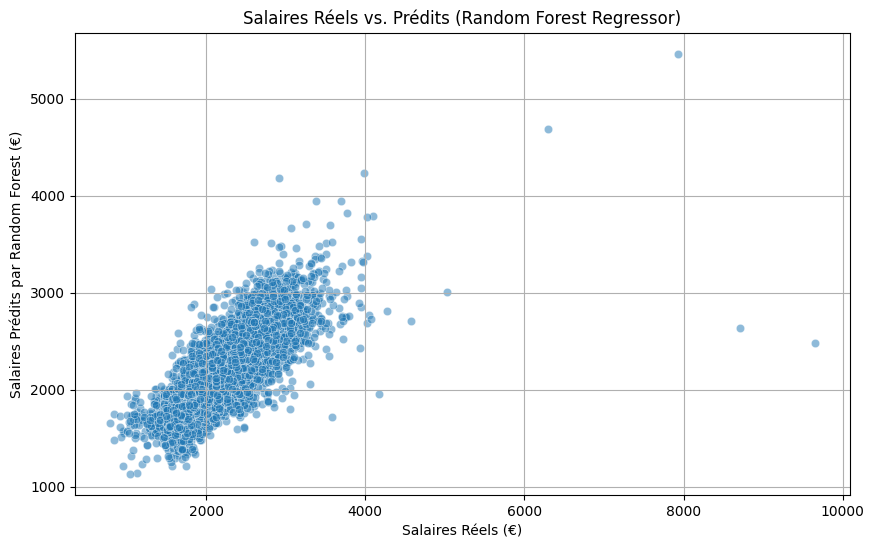

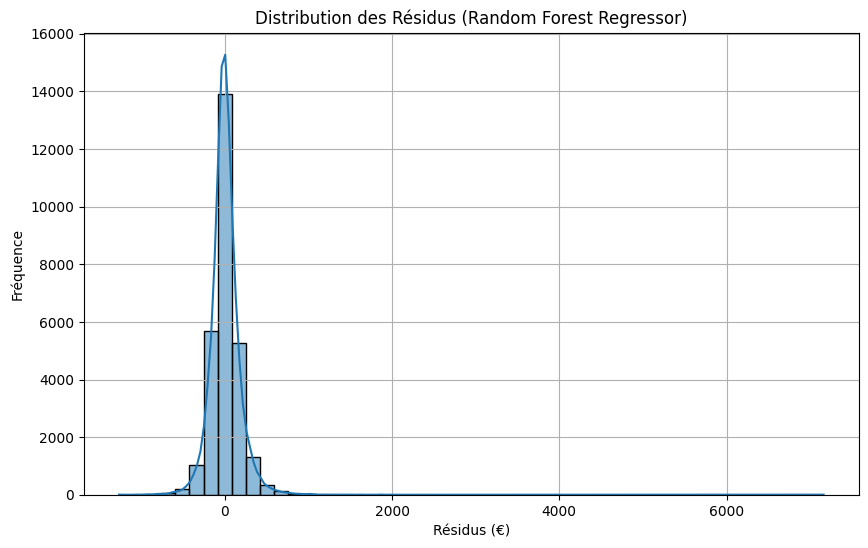

In [185]:
# 11. Visualisation des résultats du modèle Random Forest
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.xlabel("Salaires Réels (€)")
plt.ylabel("Salaires Prédits par Random Forest (€)")
plt.title("Salaires Réels vs. Prédits (Random Forest Regressor)")
plt.grid(True)
plt.show()

# Histogram of residuals
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, bins=50, kde=True)
plt.xlabel("Résidus (€)")
plt.ylabel("Fréquence")
plt.title("Distribution des Résidus (Random Forest Regressor)")
plt.grid(True)
plt.show()

Utilisation de GradientBoostingRegressor

In [186]:
# Initialisation du modèle
gbr = GradientBoostingRegressor(random_state=42)

# 1) Détection des types de colonnes
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# 2) Préprocessing : StandardScaler pour numériques, OneHotEncoder pour catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),  # évite conflits avec sortie sparse
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ],
    remainder="drop"
)

# 4) Pipeline complet
gbr_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", gbr)
])

# 5) Entraînement + prédiction
gbr_pipe.fit(X_train, y_train)
y_pred_gbr = gbr_pipe.predict(X_test)

# 6) Évaluation
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

r2_gbr = r2_score(y_test, y_pred_gbr)

print("📊 Résultats du modèle Gradient Boosting Regressor")
print(f"MAE  : {mae_gbr:.4f}")
print(f"RMSE : {rmse_gbr:.4f}")
print(f"R²   : {r2_gbr:.4f}")

📊 Résultats du modèle Gradient Boosting Regressor
MAE  : 125.4283
RMSE : 193.5454
R²   : 0.7189


GradientBoosting + KFold Cross-Validation

In [187]:
# Detect column types
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Preprocessor (use sparse=True for sklearn compat)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
])

gbr = GradientBoostingRegressor(random_state=42)

gbr_cv_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", gbr)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    gbr_cv_pipe, X_train, y_train,
    cv=cv,
    scoring={"MAE":"neg_mean_absolute_error","RMSE":"neg_root_mean_squared_error","R2":"r2"},
    n_jobs=-1, return_train_score=False
)

cv_table = pd.DataFrame({
    "MAE (↓)": -scores["test_MAE"],
    "RMSE (↓)": -scores["test_RMSE"],
    "R2 (↑)": scores["test_R2"]
})
print(cv_table.round(3))
print("\nMoyennes CV:", cv_table.mean().round(3).to_dict())

   MAE (↓)  RMSE (↓)  R2 (↑)
0  126.249   188.528   0.728
1  126.871   189.586   0.733
2  127.256   196.600   0.720
3  124.395   182.568   0.737
4  124.562   187.259   0.726

Moyennes CV: {'MAE (↓)': 125.867, 'RMSE (↓)': 188.908, 'R2 (↑)': 0.729}


**•	Présention des insights en plus de la prédiction**

Principaux enseignements de l’analyse des salaires

À partir de l’exploration des données et de la modélisation, voici les points clés qui ressortent :

1. Influence de la catégorie socio-professionnelle (PCS_ESE)

Le boxplot « Salaire par catégorie socio-professionnelle » montre clairement que les différentes professions présentent des distributions de salaires très distinctes. Certaines catégories se distinguent avec des médianes et moyennes nettement plus élevées que d’autres, confirmant l’importance du facteur professionnel dans la détermination du salaire.

2. Effet du sexe et de la région

Sexe : Le boxplot « Salaire par sexe » met en évidence une différence notable dans la distribution des salaires entre hommes et femmes, suggérant un écart salarial lié au genre.

Région (GEO) : Le graphique « Top 10 des régions avec les salaires moyens les plus élevés » illustre l’impact géographique sur les revenus, certaines régions offrant des salaires en moyenne supérieurs aux autres.

Le modèle Random Forest, qui intègre la variable GEO, a bien capturé cet effet régional, ce qui a contribué à ses meilleures performances par rapport au modèle de régression linéaire.

3. Évolution dans le temps

Le graphique « Évolution du salaire médian par année » montre la tendance des salaires médians au fil des années. On peut ainsi observer si les salaires ont eu tendance à augmenter, diminuer ou rester stables pendant la période étudiée.